In [1]:
import numpy as np
from osgeo import gdal, osr
from tqdm import tqdm, trange
import torch
import matplotlib.pyplot as plt

from esd_quantizer import Quantizer

In [2]:
tile_name = "36RUU"

dtset = gdal.Open(f"./SDC30_EBD_V001_{tile_name}_2024.tif")
ESD_codes = dtset.ReadAsArray()
dtset = None;    del dtset

ESD_codes.shape, ESD_codes.dtype

((13, 3600, 3600), dtype('uint16'))

# 1. QA band

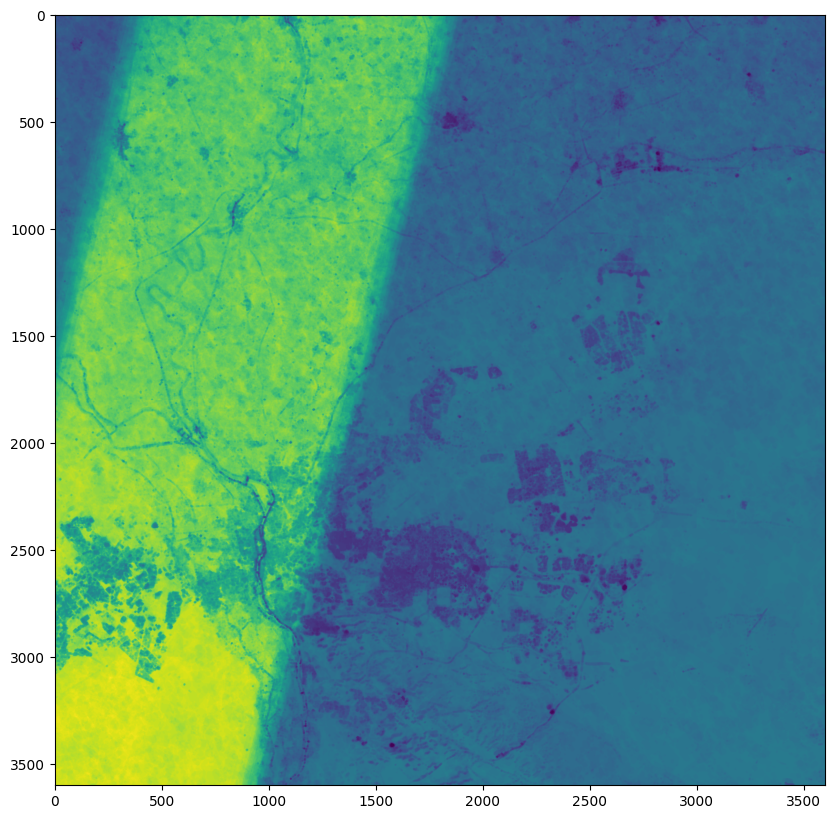

In [3]:
## The last dimension is the number of cloud-free Landsat observations used in the original inputs
plt.figure(figsize=(10, 10))
plt.imshow(ESD_codes[12])

# 2. Convert ESD codes to vectors

In [4]:
quantizer = Quantizer()
quantizer.load_state_dict(torch.load("ESD_quantizer.pth"))

ESD_vectors = np.empty([12, 6, 3600, 3600], dtype=np.float32)
for ir in trange(3600):
    with torch.no_grad():
        quantized = quantizer.indices_to_codes(torch.from_numpy(ESD_codes[:12, ir, :].astype(np.int32)))
        quantized = quantized.permute([0,2,1])
        ESD_vectors[:, :, ir, :] = quantized[:, :, :].cpu().numpy()

ESD_vectors.shape  ## (months, channels, height, width)

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:03<00:00, 973.82it/s]


(12, 6, 3600, 3600)

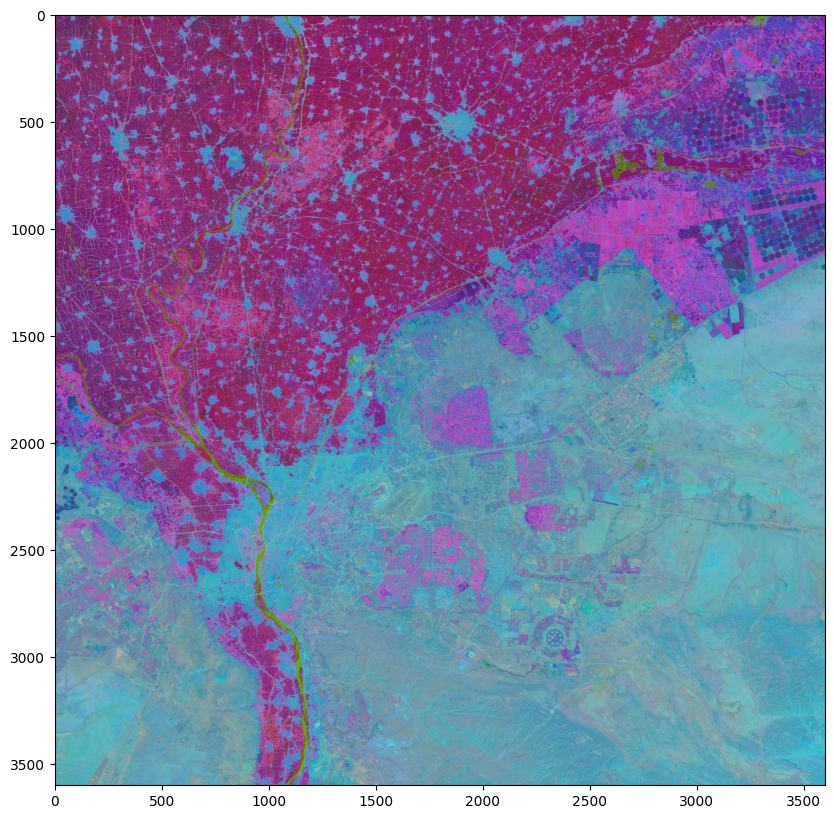

In [5]:
def ESD2IMG(codes, vectors):
    valid_mask = ~np.all(codes[:12] == 0, axis=0)
    # Convert to RGB image
    disp_img = np.zeros([3600, 3600, 4], dtype=np.uint8)  # RGBA
    disp_img[:, :, 0] = (np.mean(vectors[:, 5], axis=0) + 1) / 2 * 255
    disp_img[:, :, 1] = (np.mean(vectors[:, 1], axis=0) + 1) / 2 * 255
    disp_img[:, :, 2] = (np.mean(vectors[:, 2], axis=0) + 1) / 2 * 255
    # Mask areas without valid ESD data
    disp_img[:, :, 3] = np.where(valid_mask, 255, 0).astype(np.uint8)
    return disp_img


plt.figure(figsize=(10, 10))
plt.imshow(ESD2IMG(ESD_codes, ESD_vectors))